In [2]:
from tqdm import tqdm
import pandas as pd
import math
import numpy as np
pd.set_option('max_rows',2000)
estonian = pd.read_excel(open('EstonianData.xlsx', 'rb'), sheet_name='Candidates')
Candidates=np.array(estonian['Candidates'].values.tolist())
RegNumbers=np.array(estonian['RegNum'].values.tolist())
Party=np.array(estonian['Party'].values.tolist())
District=np.array(estonian['District'].values.tolist())
Votes=np.array(estonian['Votes'].values.tolist())
Mandate=np.array(estonian['Mandate'].values.tolist())
Mandates=np.array(estonian['Mandates'].values.tolist())
PartyCode=np.array(estonian['PartyCode'].values.tolist())
PartyNames=np.array(estonian['PartyNames'].values.tolist())


def truncate(number, decimals=4):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor




ElectoralThreshold=0.05*sum(Votes)

def District_Quota(j):
    sum=0
    for i in range(len(Candidates)):
        if District[i]==j :
            sum=sum+ Votes[i]
            #print(Candidates[i],'====',i)
    return float("{:.2f}".format(sum/Mandates[j-1]))


def PersonalMandates():
    Personal_Mandate_Vector = [0] * 12
    print("The list of candidates elligible by personal mandates levels are as bellow ")
    for i in range(len(Candidates)):
        if Votes[i] >= District_Quota(District[i]):
            Personal_Mandate_Vector[PartyCode[i]]=Personal_Mandate_Vector[PartyCode[i]]+1
            print("=================================================================================")
            print(RegNumbers[i], "----", Candidates[i],"----",Party[i], PartyCode[i])
    print("=================================================================================")
    return(Personal_Mandate_Vector)


def Personal_Mandate_Checker(i):
    if Votes[i] >= District_Quota(District[i]):
        return True
    else:
        return False

personal=[]
for i in range(len(Candidates)):
    if Personal_Mandate_Checker(i):
        personal.append(i)
        
        


def District_Personal_Mandate_Distributation_by_Party(district):
    district_by_party_vector=[0]*12
    for i in range(len(Candidates)):
        if (Votes[i]>= District_Quota(District[i]) and District[i]==district):
            district_by_party_vector[PartyCode[i]]=district_by_party_vector[PartyCode[i]]+1
    #print(district_by_party_vector)
    return district_by_party_vector

def PartyVote(j):
    sum = 0
    for i in range(len(Candidates)) :
        if (PartyCode[i]==j):
            #print(Votes[i])
            sum = sum + Votes[i]
    return sum

def Elligible_Parties():
    Elligibles=[]
    for i in range(11):
        if PartyVote(i)>=ElectoralThreshold:
            Elligibles.append(i)
    return Elligibles


def District_Mandate_Party(i):
    if (i in Elligible_Parties()):
        print('This party has ', PartyVote(i)/ElectoralThreshold, 'mandates')
    else:
        print("This party is not elligible for regional mandates")


def Party_Per_District(party,district):
    sum=0
    for k in range(len(Candidates)):
        if PartyCode[k]==party and District[k]==district:
            sum=sum + Votes[k]
    return sum


def District_Seat_Counter(party, district):
    Seat_Numer=0
    if (party in Elligible_Parties()):
        Seat_Numer=math.floor(Party_Per_District(party, district) / District_Quota(district))
        if (Party_Per_District(party, district) % District_Quota(district) >=  0.75* District_Quota(district)):
            Seat_Numer+=1
    else:
        Seat_Numer=0
    return  Seat_Numer


def District_Mandate_Vector(district):
    district_mandate=[0]*12
    for party in range(1,12):
        district_mandate[party]=District_Seat_Counter(party,district)-District_Personal_Mandate_Distributation_by_Party(district)[party]
    return district_mandate


def Allocating_District_Mandate( party , district) :
    new = estonian[(estonian['PartyCode'] == party) & (estonian['District'] == district)]
    final_index=list(set(new.index).difference(set(personal)))
    df = estonian.loc[final_index].sort_values(by=['Votes']).tail(District_Mandate_Vector(district)[party])
    dff = df[df['Votes'] >= 0.1 * District_Quota(district)]
    return (list(dff.index))


def District_Mandates_List():
    mandates_list=[]
    for party in tqdm(Elligible_Parties()):
        for district in tqdm(range(1,13)):
            mandates_list = mandates_list + Allocating_District_Mandate(party,district)
    return(mandates_list)

#####################################
distMandList = District_Mandates_List()
#####################################





def NationalPersonalParty():
    s = np.array([0]*12)
    for district in range(13):
        s = s + np.array(District_Personal_Mandate_Distributation_by_Party(district))
    return(s)


def District_National_By_Party(party):
    s = 0
    for i in range(1,13):
        s = s + len(Allocating_District_Mandate(party, i))
    return(s)

def TotalAlloctedForParty(party):
    return (NationalPersonalParty()[party]+District_National_By_Party(party))

def RemainedMandates():
    return (101 -(len(personal)+ len (distMandList)))


################
remMandate= RemainedMandates()


def Compensation_Elligible_Parties():
    CompensationElligibles=[]
    for i in range(12):
        if PartyVote(i)>=ElectoralThreshold:
            CompensationElligibles.append(i)
    return CompensationElligibles


def ComparativeFigure(party):
    totalParty = TotalAlloctedForParty(party)
    if party in Compensation_Elligible_Parties():
        vector=[truncate(i ** 0.9,4) for i in range(totalParty +1,totalParty + remMandate+1)]
        s = np.array(vector)
        vector=list(zip(list(map(truncate,list(PartyVote(party)/s))),[party] * remMandate))
    else :
        vector = None 
    return vector



def NationalComparativeFigures():
    nationalList=[]
    for party in tqdm(Compensation_Elligible_Parties()):
        nationalList = nationalList + ComparativeFigure(party)
    return nationalList
        
    
#print(NationalComparativeFigures())

Rank = pd.read_excel(open('EstonianData.xlsx', 'rb'), sheet_name='Rank')


def RankMapping(i): 
    if (estonian['PartyCode'][i]== 11):
        return 0
    else:
        return list(Rank[Rank['RegNum']== estonian['RegNum'][i]]['Rank'])[0]

estonian['Rank']= estonian['RegNum']
for i in range(1099):
    estonian['Rank'][i] = RankMapping(i)



df = pd.DataFrame(NationalComparativeFigures())



100%|██████████| 5/5 [02:48<00:00, 33.69s/it]
/Users/ehsan.estaji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 5/5 [03:08<00:00, 37.61s/it]


In [15]:
estonian

,Candidates,RegNum,PartyCode,Party,District,Mandate,Votes,Unnamed: 7,Mandates,PartyNames,Unnamed: 10,Rank
0,ANDRES HERKEL,101,1,Eesti Vabaerakond,1,10,222,10.0,10.0,Eesti Vabaerakond,NaN,3
1,ÕIE-MARI AASMÄE,102,1,Eesti Vabaerakond,1,10,43,NaN,13.0,Eesti Reformierakond,REF,22
2,JAAK PROZES,103,1,Eesti Vabaerakond,1,10,35,NaN,8.0,Erakond Eestimaa Rohelised,NaN,33
3,JAANIKA KLOPETS,104,1,Eesti Vabaerakond,1,10,23,NaN,15.0,Sotsiaaldemokraatlik Erakond,SDE,41
4,JAANUS OJANGU,105,1,Eesti Vabaerakond,1,10,15,NaN,6.0,Elurikkuse Erakond,NaN,9
5,JÜRI PINO,106,1,Eesti Vabaerakond,1,10,36,NaN,5.0,Eesti Konservatiivne Rahvaerakond,EKRE,39
6,JAANUS PAASOJA,107,1,Eesti Vabaerakond,1,10,9,NaN,7.0,Erakond Eesti 200,NaN,53
7,PEETER LIINSOO,108,1,Eesti Vabaerakond,1,10,5,NaN,7.0,Eesti Keskerakond,KESK,65
8,MARIKE LAHT,109,1,Eesti Vabaerakond,1,10,18,NaN,7.0,Eestimaa Ühendatud Vasakpartei,NaN,77
9,SANDER KLAUSEN,110,1,Eesti Vabaerakond,1,10,12,NaN,8.0,Isamaa Erakond,IE,89


In [9]:

removeCompensation = personal + distMandList
final_index=list(set(estonian.index).difference(set(removeCompensation)))
estonian_new =  estonian.iloc[final_index]
estonian_new.head()
dff = df.sort_values(by=0, ascending= False).head(remMandate)
CompensationSeatsPerParty = dff[1].value_counts()

estonian_new['Quota'] = estonian_new['District']
for i in final_index:
    estonian_new['Quota'][i] = District_Quota(estonian_new['District'][i])*0.05
    
def CompensationIndexSet():
    result=[]
    for party in Compensation_Elligible_Parties():
        compensResult = estonian_new[(estonian_new['PartyCode'] == party) & (estonian_new['Votes']>= estonian_new['Quota'])].sort_values(by='Rank', ascending = True).head(CompensationSeatsPerParty[party])
        result = result + list(compensResult.index)
    return result

    


/Users/ehsan.estaji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ehsan.estaji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [46]:
estonian_visual = estonian[['Candidates','RegNum', 'PartyCode','District','Votes']]

In [47]:
estonian_visual.iloc[CompensationIndexSet()]

,Candidates,RegNum,PartyCode,District,Votes
124,ANDRES SUTT,240,2,2,1905
490,Reg. No. 281 URVE TIIDUS,281,2,5,2617
253,VILJA TOOMAST,255,2,3,953
254,JOHANNES KERT,256,2,3,708
941,Reg. No. 335 ANDRUS SEEME,335,2,11,764
1030,Reg. No. 344 JÜRI JAANSON,344,2,12,1139
493,Reg. No. 284 HEIKI KRANICH,284,2,5,390
961,Reg. No. 585 KALVI KÕVA,585,4,11,605
37,RIINA SIKKUT,477,4,1,1610
574,Reg. No. 538 INDREK SAAR,538,4,6,1332


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected= True)
cf.go_offline()

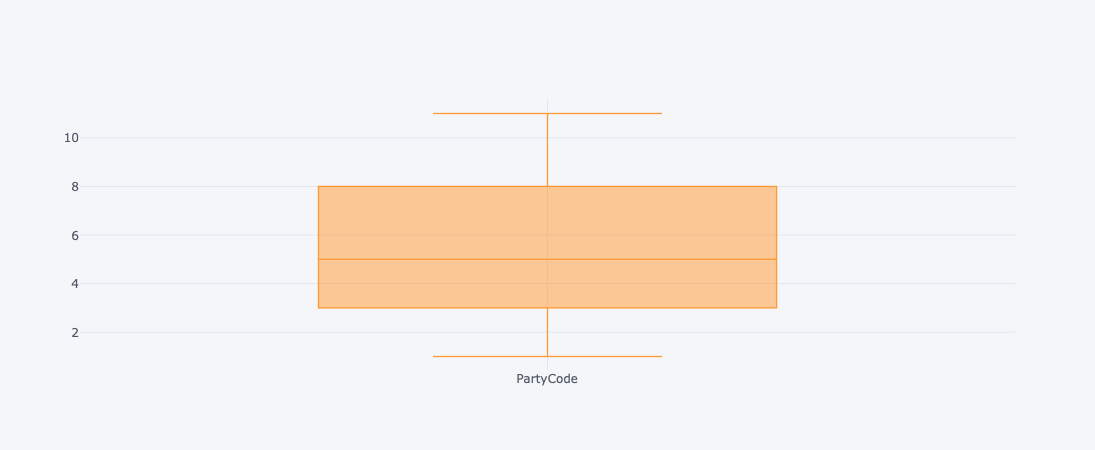

In [18]:
estonian_visual['PartyCode'].iplot(kind = 'box')

In [19]:
final_elected_list = personal + distMandList + CompensationIndexSet()

In [20]:
len(final_elected_list)

101

In [48]:
Final_Result = estonian_visual.iloc[final_elected_list]

In [49]:
Final_Result

,Candidates,RegNum,PartyCode,District,Votes
12,KRISTEN MICHAL,226,2,1,6347
80,RAIMOND KALJULAID,924,8,1,7303
122,SIIM KALLAS,238,2,2,8733
206,MIHHAIL KÕLVART,936,8,2,17150
251,URMAS PAET,253,2,3,8584
...,...,...,...,...,...
748,Reg. No. 1003 KERSTI SARAPUU,1003,8,8,1394
85,KALEV KALLO,929,8,1,289
998,Reg. No. 1031 ANNELI OTT,1031,8,11,1474
222,SVEN SESTER,1072,10,2,1154


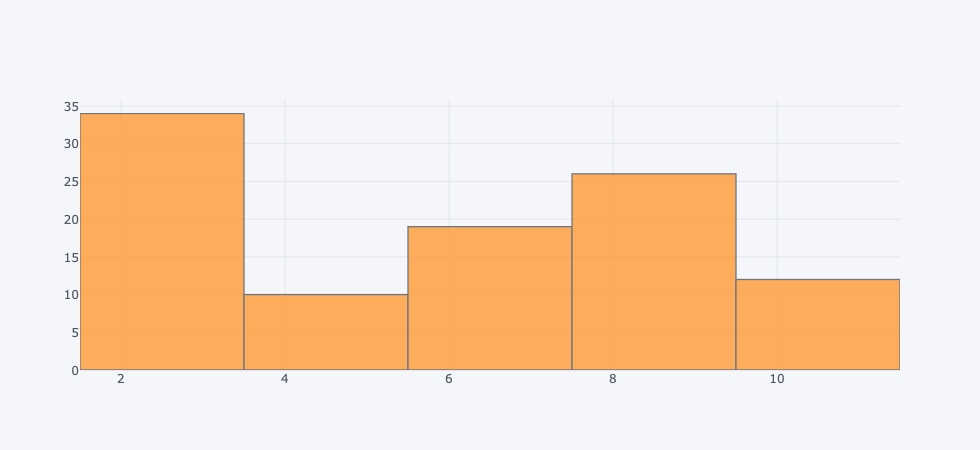

In [28]:
Final_Result['PartyCode'].iplot(kind= 'hist')

In [52]:
Final_Result['Type']= [0]*101

In [70]:
Final_Result.loc[personal]['Type']=[2] * len(personal)

In [80]:
Final_Result['Type'].loc[personal] = ['Personal Mandate'] *len(personal)
Final_Result['Type'].loc[distMandList] = ['District Mandate'] * len(distMandList)
Final_Result['Type'].loc[CompensationIndexSet()] = ['Compensation Manadate'] * (len(CompensationIndexSet()))
Final_Result

,Candidates,RegNum,PartyCode,District,Votes,Type
12,KRISTEN MICHAL,226,2,1,6347,Personal Mandate
80,RAIMOND KALJULAID,924,8,1,7303,Personal Mandate
122,SIIM KALLAS,238,2,2,8733,Personal Mandate
206,MIHHAIL KÕLVART,936,8,2,17150,Personal Mandate
251,URMAS PAET,253,2,3,8584,Personal Mandate
...,...,...,...,...,...,...
748,Reg. No. 1003 KERSTI SARAPUU,1003,8,8,1394,Compensation Manadate
85,KALEV KALLO,929,8,1,289,Compensation Manadate
998,Reg. No. 1031 ANNELI OTT,1031,8,11,1474,Compensation Manadate
222,SVEN SESTER,1072,10,2,1154,Compensation Manadate


In [90]:
Final_Result

,Candidates,RegNum,PartyCode,District,Votes,Type
12,KRISTEN MICHAL,226,2,1,6347,Personal Mandate
80,RAIMOND KALJULAID,924,8,1,7303,Personal Mandate
122,SIIM KALLAS,238,2,2,8733,Personal Mandate
206,MIHHAIL KÕLVART,936,8,2,17150,Personal Mandate
251,URMAS PAET,253,2,3,8584,Personal Mandate
...,...,...,...,...,...,...
748,Reg. No. 1003 KERSTI SARAPUU,1003,8,8,1394,Compensation Manadate
85,KALEV KALLO,929,8,1,289,Compensation Manadate
998,Reg. No. 1031 ANNELI OTT,1031,8,11,1474,Compensation Manadate
222,SVEN SESTER,1072,10,2,1154,Compensation Manadate


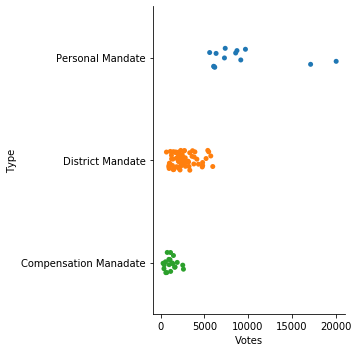

In [93]:
sns.catplot(x='Votes', y='Type', data=Final_Result)

# Personal Mandates

In [96]:
Final_Result.loc[personal]

,Candidates,RegNum,PartyCode,District,Votes,Type
12,KRISTEN MICHAL,226,2,1,6347,Personal Mandate
80,RAIMOND KALJULAID,924,8,1,7303,Personal Mandate
122,SIIM KALLAS,238,2,2,8733,Personal Mandate
206,MIHHAIL KÕLVART,936,8,2,17150,Personal Mandate
251,URMAS PAET,253,2,3,8584,Personal Mandate
345,Reg. No. 263 KAJA KALLAS,263,2,4,20072,Personal Mandate
409,Reg. No. 711 HENN PÕLLUAAS,711,6,4,7390,Personal Mandate
443,Reg. No. 961 JÜRI RATAS,961,8,4,9702,Personal Mandate
669,Reg. No. 993 YANA TOOM,993,8,7,6195,Personal Mandate
697,Reg. No. 304 JÜRGEN LIGI,304,2,8,6069,Personal Mandate


# District Mandates

In [105]:
Final_Result.loc[distMandList]

,Candidates,RegNum,PartyCode,District,Votes,Type
14,ARTO AAS,228,2,1,2339,District Mandate
13,HEIDY PURGA,227,2,1,4763,District Mandate
125,KRISTINA ŠMIGUN-VÄHI,241,2,2,2002,District Mandate
123,KEIT PENTUS-ROSIMANNUS,239,2,2,2482,District Mandate
252,MARIS LAURI,254,2,3,4331,District Mandate
348,Reg. No. 266 KALLE PALLING,266,2,4,1655,District Mandate
351,Reg. No. 269 MADIS MILLING,269,2,4,2310,District Mandate
347,Reg. No. 265 AIVAR SÕERD,265,2,4,2476,District Mandate
346,Reg. No. 264 MARKO MIHKELSON,264,2,4,3655,District Mandate
489,Reg. No. 280 KALLE LAANET,280,2,5,3344,District Mandate


# Compensation Mandates

In [106]:
Final_Result.loc[CompensationIndexSet()]

,Candidates,RegNum,PartyCode,District,Votes,Type
124,ANDRES SUTT,240,2,2,1905,Compensation Manadate
490,Reg. No. 281 URVE TIIDUS,281,2,5,2617,Compensation Manadate
253,VILJA TOOMAST,255,2,3,953,Compensation Manadate
254,JOHANNES KERT,256,2,3,708,Compensation Manadate
941,Reg. No. 335 ANDRUS SEEME,335,2,11,764,Compensation Manadate
1030,Reg. No. 344 JÜRI JAANSON,344,2,12,1139,Compensation Manadate
493,Reg. No. 284 HEIKI KRANICH,284,2,5,390,Compensation Manadate
961,Reg. No. 585 KALVI KÕVA,585,4,11,605,Compensation Manadate
37,RIINA SIKKUT,477,4,1,1610,Compensation Manadate
574,Reg. No. 538 INDREK SAAR,538,4,6,1332,Compensation Manadate


In [107]:
import pandas as pd
import numpy as np
import cufflinks as cf
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

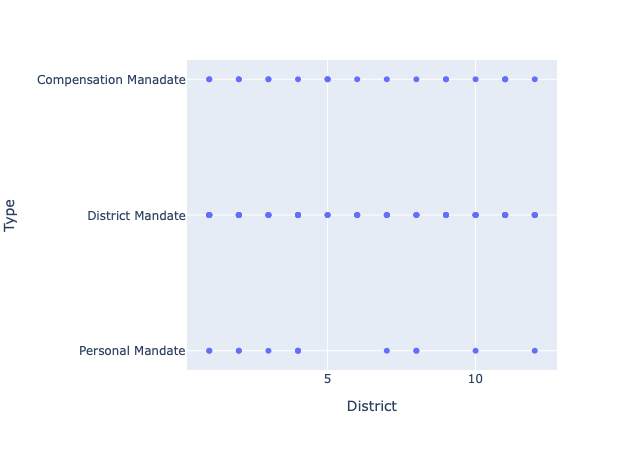

In [112]:
# x and y given as DataFrame columns
import plotly.express as px
fig = px.scatter(Final_Result, x="District", y="Type")
fig.show()


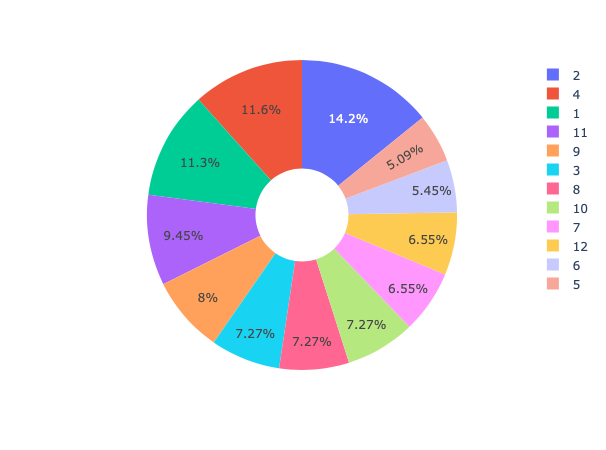

In [124]:
fig = px.pie(Final_Result, values='PartyCode',names='District', hole= 0.3)

fig.show()

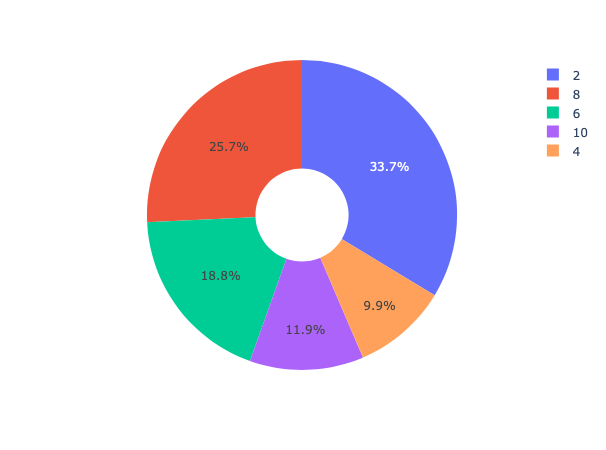

In [126]:
fig = px.pie(Final_Result,names='PartyCode', hole= 0.3)
fig.show()